## Table of content

| Chapter                                                                                             | Description                                    |
|:----------------------------------------------------------------------------------------------------|:-----------------------------------------------|
| [Data description](#data-description)                                                               | This chapter provides a short brief about data |
| [Imports](#imports)                                                                                 | All imported modules                           |
| [Data loading](#data-loading)                                                                       | Loading data from fils                         |
| [Plots](#plots)                                                                                     | Shows some problems in data                    |
| [Baseline](#baseline)                                                                               | Baseline for comparing                         |
| [SARIMA Train/Test/Validation Pipeline](#sarima-traintestvalidation-pipeline)                       | SARIMA training and evaluating                 |
| [Gradient boosting Train/Test/Validation Pipeline](#gradient-boosting-traintestvalidation-pipeline) | Gradient boosting training and evaluating      |
| [Conclusion](#conclusion)                                                                           | Conclusion of notebook                         |

## Data description

This dataset provides historical sales data for an e-commerce platform in Russia. It consists of five files containing information on items, categories, shops, and sales transactions from January 2013 to October 2015.

### File Description

`items.csv`

* item_name: string - Name of the good.
* item_id: integer - Primary key, a unique identifier for each item.
* item_category_id: integer - Foreign key linking to item_categories.csv.

`item_categories.csv`

* item_category_name: string - Name of the product category.
* item_category_id: integer - Primary key, a unique identifier for each category.

`shops.csv`

* shop_name: string - Name of the shop.
* shop_id: integer - Primary key, a unique identifier for each shop.

`sales_train.csv`

* date: datetime - Date of purchase in dd.mm.yyyy format.
* date_block_num: integer - A unique monthly identifier. January 2013 is 0, February 2013 is 1, and so on.
* shop_id: integer - Foreign key linking to shops.csv.
* item_id: integer - Foreign key linking to items.csv.
* item_price: float - The price of the item in Russian Rubles (RUB).
* item_cnt_day: integer - The number of units of the item sold on a specific day. This value can be negative due to returns.

## Imports

In [2]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBRegressor, XGBRFRegressor

from Pipeline import ConditionDropper, DateDivider, DifferenceGenerator, GroupAndSummarize, LagFeatureGenerator, MovingAverageGenerator, NanDropper

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data loading

In [3]:
raw_data: pd.DataFrame = pd.read_csv('data/sales_post_process.csv', parse_dates=['date'], date_format='%Y-%m-%d')
raw_data.asfreq("D")
X_sarima = [raw_data[raw_data["cluster"] == i] for i in range(int(raw_data["cluster"].max() + 1))]

## Plots

In [ ]:
fig, ax = plt.subplots(nrows=10, figsize=(10, 50))

for index, cluster in enumerate(X_sarima):
    ploted_data_df = cluster.groupby(["date"])["item_cnt_day"].sum().reset_index()
    ax[index].set_title(f"Cluster {index + 1}")
    ax[index].set_xlabel("Date")
    ax[index].set_ylabel("Sales")
    sns.lineplot(data=ploted_data_df, x="date", y="item_cnt_day", ax=ax[index])

1. There are clusters with very different curves (for instance cluster 9), It's clear to explore such cluster separately and find more optimal parameters for SARIMA models. I'll explore 1, 5, 6, and 9 clusters separately.

### Clusters exploring

In [4]:
cluster_1 = X_sarima[0].groupby(["date"])["item_cnt_day"].sum()
cluster_5 = X_sarima[4].groupby(["date"])["item_cnt_day"].sum()
cluster_6 = X_sarima[5].groupby(["date"])["item_cnt_day"].sum()
cluster_9 = X_sarima[8].groupby(["date"])["item_cnt_day"].sum()

#### ACF and PACF

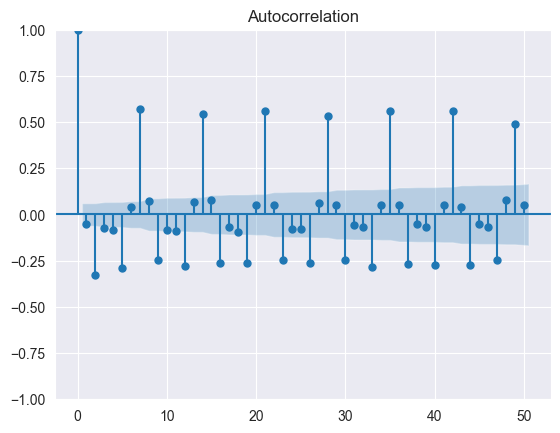

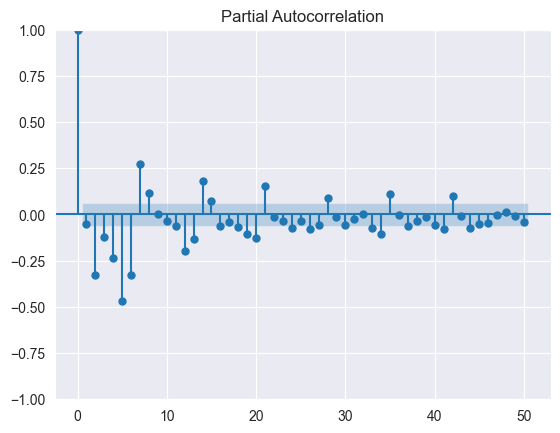

In [5]:
plot_acf(cluster_1.diff(1).dropna(), lags=50)
plot_pacf(cluster_1.diff(1).dropna(), lags=50)
None

1. ACF plot shows cuts-off pattern on second lag, It's parameter of MA process.
2. PACF plot shows tails-off pattern on second lag, I'll use it for AR process.
3. Seasonality each 7 lags, I'll use 1 lag for AR process, and 2 lags for MA process.

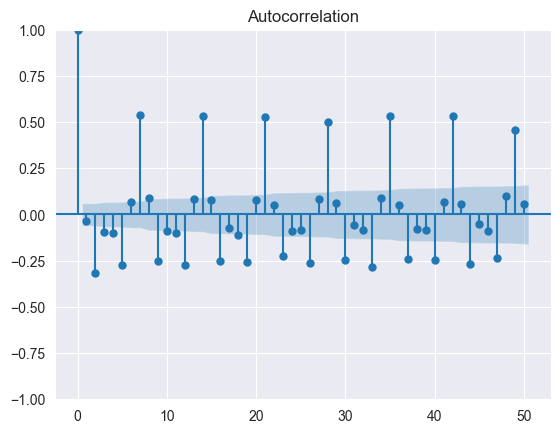

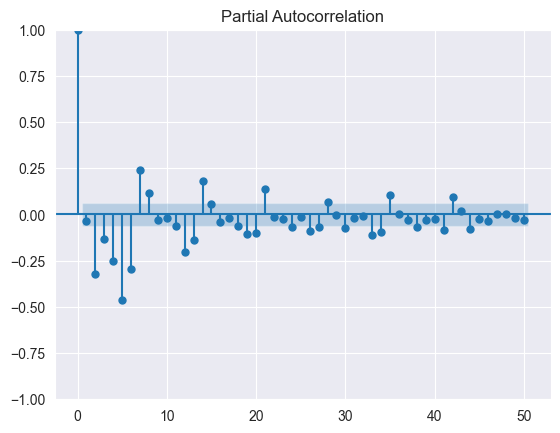

In [6]:
plot_acf(cluster_5.diff(1).dropna(), lags=50)
plot_pacf(cluster_5.diff(1).dropna(), lags=50)
None

1. ACF plot shows cuts-off pattern on second lag, It's parameter of MA process.
2. PACF plot shows tails-off pattern on second lag, I'll use it for AR process.
3. Seasonality each 7 lags, I'll use 1 lag for AR process, and 2 lags for MA process.

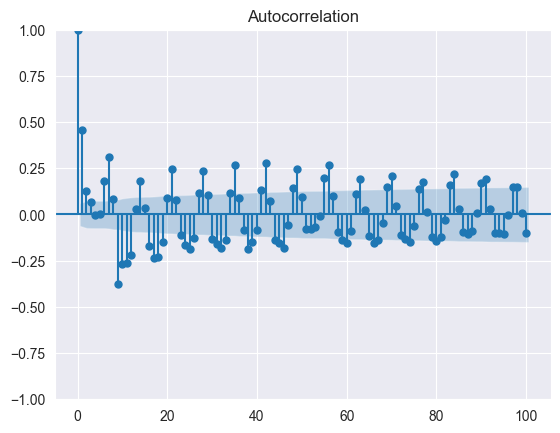

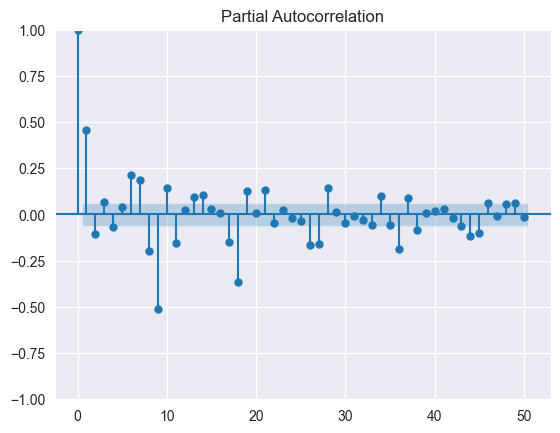

In [7]:
plot_acf(cluster_6.diff(9).dropna(), lags=100)
plot_pacf(cluster_6.diff(9).dropna(), lags=50)
None

1. ACF plot shows tails-off pattern, and PACF shows cuts-off pattern, it means that model can use only AR process for modeling, PACF plot shows cuts-off pattern on first lag, it's an order for AR process.
2. Seasonality each 9 lags,  and shows tails-off pattern, I'll use 2 lags for AR process and 2 lags for MA process.

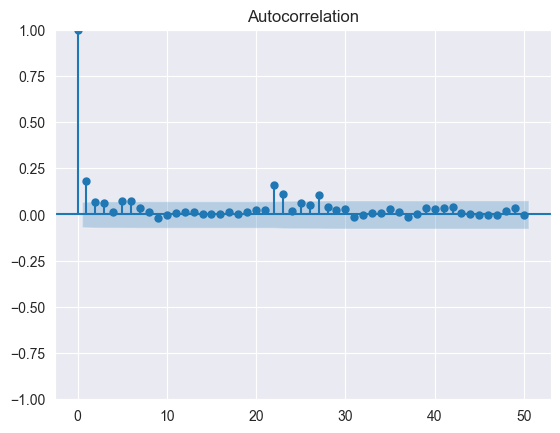

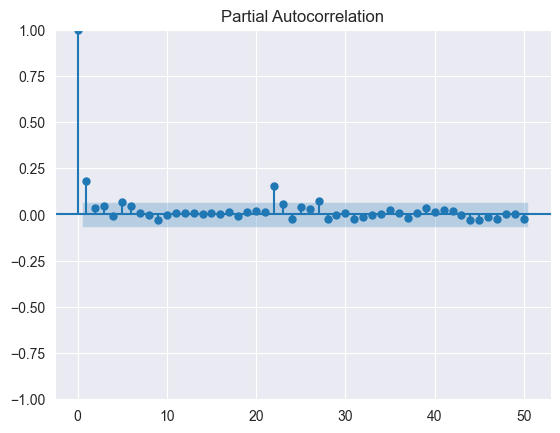

In [8]:
plot_acf(cluster_9, lags=50)
plot_pacf(cluster_9, lags=50)
None

1. Both ACF and PACF shows cuts-off pattern, it means that timeseries is noisy and unpredictable, but I'll try first lag for both processes.

#### Stationarity test

In [9]:
result = adfuller(cluster_1.diff(1).dropna())
print(f"result: {result[1]}")

result: 5.5920912713622566e-15


In [10]:
result = adfuller(cluster_5.diff(1).dropna())
print(f"result: {result[1]}")

result: 9.273188186382774e-15


In [11]:
result = adfuller(cluster_6.diff(1).dropna())
print(f"result: {result[1]}")

result: 5.120459742981269e-20


In [12]:
result = adfuller(cluster_9.diff(1).dropna())
print(f"result: {result[1]}")

result: 1.3625998192540744e-21


First difference for each series is stationary, so I'll use 1 value for parameter d.

### Data Balance

   item_cnt_day    count
0             1  2450992
1             2   178758
2             3    40767
3             4    15460
4             5     7558
5             6     4284
6             7     2590
7             8     1797
8             9     1232
9            10     1104


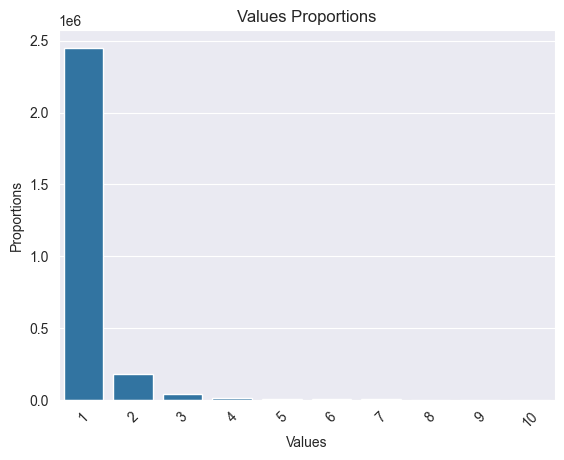

In [191]:
grouped_df = raw_data.groupby(["date", "shop_id", "item_id"])["item_cnt_day"].sum().reset_index()
data_proportions = grouped_df["item_cnt_day"].value_counts().reset_index()
print(data_proportions.head(10))
plt.title("Values Proportions")
plt.xlabel("Values")
plt.xticks([i for i in range(10)], rotation=45)
plt.ylabel("Proportions")
sns.barplot(data_proportions, x="item_cnt_day", y="count")
plt.show()

1. Data is highly imbalanced, the most records contains 1 as target variable.
2. There are very rare values and they start from 10. So it's clear to drop records where target variable greater than 10.
3. It's good idea to create some baseline, and created model must be better than this baseline. The simplest baseline, always predict 1, because around 91% of records contain 1 as target variable.

## Baseline

In [133]:
baseline_pipeline = Pipeline([
    ("GroupAndSummarize1", GroupAndSummarize(group_by_col=["shop_id", "date", "item_id"], agg_dict={"item_cnt_day": "sum"})),
    ("ConditionDropper", ConditionDropper("item_cnt_day", lambda df: (df > 20) | (df < 0))),

    ("LagFeatureGenerator_target", LagFeatureGenerator(column="item_cnt_day", lags=[-31], group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),
    ("NanDropper1", NanDropper(columns=["item_cnt_day_lag_-31"])),

    ("MovingAverageGenerator1", MovingAverageGenerator(column="item_cnt_day", window_size=30, min_periods=1, group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),

    ("DifferenceGenerator1", DifferenceGenerator(columns=["item_cnt_day"], lag=1, count=1, group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),
    ("NanDropper2", NanDropper(columns=["item_cnt_day_diff_lag1_c1"])),

    ("LagFeatureGenerator2", LagFeatureGenerator(column="item_cnt_day_diff_lag1_c1", lags=[1], group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),
    ("NanDropper3", NanDropper(columns=["item_cnt_day_diff_lag1_c1_lag_1"])),

    ("MovingAverageGenerator2", MovingAverageGenerator(column="item_cnt_day_diff_lag1_c1", window_size=30, min_periods=1, group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),

    ("DateDivider", DateDivider(column="date")),
])

baseline_preprocessed_data = baseline_pipeline.transform(raw_data)
baseline_train = baseline_preprocessed_data[(baseline_preprocessed_data["year"] == 2015) & (baseline_preprocessed_data["month"] > 8)]
baseline_test = baseline_preprocessed_data.drop(baseline_train.index)

In [134]:
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_index, test_index) in enumerate(tscv.split(baseline_train)):
    ts_test = baseline_train.iloc[test_index]

    y_test = ts_test["item_cnt_day_lag_-31"]
    y_pred = np.array([1] * len(y_test))

    print(f"Fold {fold}: {root_mean_squared_error(y_test, y_pred)}")

y_test = baseline_test["item_cnt_day_lag_-31"]
y_pred = np.array([1] * len(y_test))
baseline_test_rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test (RMSE): {baseline_test_rmse}")

Fold 0: 2.04494943258218
Fold 1: 2.0743746775908884
Fold 2: 2.309401076758503
Fold 3: 1.834021909257456
Fold 4: 1.954016841836789
Test (RMSE): 0.9453897453370715


## SARIMA Train/Test/Validation Pipeline

### Pipeline

In [26]:
sarima_test = [raw_data[(raw_data["date"] > "2015-09-30") & (raw_data["cluster"] == i)] for i in range(10)]
sarima_train = [X_sarima[i].drop(sarima_test[i].index) for i in range(10)]

sarima_pipeline: Pipeline = Pipeline([
    ("GroupAndSummarize", GroupAndSummarize(group_by_col=["date"], agg_dict={"item_cnt_day": "sum"})),
])

### Train/Test/Validation Loop

In [27]:
sarima_tscv = TimeSeriesSplit(n_splits=5)

parameters = [
    [(2, 1, 2), (2, 1, 1, 7)],
    [(6, 1, 2), (1, 1, 1, 7)],
    [(6, 1, 2), (1, 1, 1, 7)],
    [(6, 1, 2), (1, 1, 1, 7)],
    [(2, 1, 2), (2, 1, 1, 7)],
    [(0, 1, 1), (2, 1, 2, 9)],
    [(6, 1, 2), (1, 1, 1, 7)],
    [(6, 1, 2), (1, 1, 1, 7)],
    [(1, 1, 1), (0, 0, 0, 0)],
    [(6, 1, 2), (1, 1, 1, 7)],
]
models: dict[int, SARIMAXResults] = {}

for cluster_id, cluster in enumerate(sarima_train):
    x = sarima_pipeline.transform(cluster)
    print(f"Cluster {cluster_id + 1}:")
    for fold, (train_index, test_index) in enumerate(sarima_tscv.split(x)):
        ts_train, ts_test = x.iloc[train_index].set_index("date"), x.iloc[test_index].set_index("date")
        model = SARIMAX(
            ts_train.asfreq("D"),
            order=parameters[cluster_id][0],
            seasonal_order=parameters[cluster_id][1]
        )
        models[cluster_id] = model.fit()
        ts_pred = models[cluster_id].forecast(steps=len(ts_test))
        print(f"fold {fold}/{len(test_index)}: {root_mean_squared_error(ts_test, ts_pred)}")

print("Test (RMSE):")

sarima_test_mean_rmse = 0

for cluster_id, cluster in enumerate(sarima_test):
    test = sarima_pipeline.transform(cluster).set_index("date")
    ts_pred = models[cluster_id].forecast(steps=len(test))
    sarima_test_rmse = root_mean_squared_error(test, ts_pred)
    sarima_test_mean_rmse += sarima_test_rmse
    print(f"Cluster {cluster_id + 1}: {sarima_test_rmse}")

sarima_test_mean_rmse /= 10

Cluster 1:
fold 0/167: 157.06226343966327
fold 1/167: 409.4605406036595
fold 2/167: 197.69122081510406
fold 3/167: 365.6482179642022
fold 4/167: 210.9106156287538
Cluster 2:
fold 0/166: 44.65210782477105
fold 1/166: 26.667248050454788
fold 2/166: 17.409844839888414
fold 3/166: 27.70878441127463
fold 4/166: 17.308150721234295
Cluster 3:
fold 0/167: 29.40918280444944
fold 1/167: 34.93492744650854
fold 2/167: 23.04396417671669
fold 3/167: 37.91621565354495
fold 4/167: 26.985738063082323
Cluster 4:
fold 0/163: 30.308992930192513
fold 1/163: 31.17949780049312
fold 2/163: 18.393659678765257
fold 3/163: 27.071488366867403
fold 4/163: 20.182711684657956
Cluster 5:
fold 0/167: 414.856303581565
fold 1/167: 804.4493938152052
fold 2/167: 376.7949377651739
fold 3/167: 863.0110569268137
fold 4/167: 525.794967091366
Cluster 6:
fold 0/166: 91.49657964337437
fold 1/166: 169.02441327005894
fold 2/166: 131.22368890732395
fold 3/166: 225.49331743261294
fold 4/166: 111.25484988802776
Cluster 7:
fold 0/166:

## Gradient boosting Train/Test/Validation Pipeline

### Pipeline

In [4]:
boosting_prevalidation_pipeline = Pipeline([
    ("GroupAndSummarize1", GroupAndSummarize(group_by_col=["shop_id", "date", "item_id"], agg_dict={"item_cnt_day": "sum"})),
    ("ConditionDropper", ConditionDropper("item_cnt_day", lambda df: (df > 20) | (df < 0))),

    ("LagFeatureGenerator_target", LagFeatureGenerator(column="item_cnt_day", lags=[-31], group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),
    ("NanDropper1", NanDropper(columns=["item_cnt_day_lag_-31"])),

    ("MovingAverageGenerator1", MovingAverageGenerator(column="item_cnt_day", window_size=30, min_periods=1, group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),

    ("DifferenceGenerator1", DifferenceGenerator(columns=["item_cnt_day"], lag=1, count=1, group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),
    ("NanDropper2", NanDropper(columns=["item_cnt_day_diff_lag1_c1"])),

    ("LagFeatureGenerator2", LagFeatureGenerator(column="item_cnt_day_diff_lag1_c1", lags=[1], group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),
    ("NanDropper3", NanDropper(columns=["item_cnt_day_diff_lag1_c1_lag_1"])),

    ("MovingAverageGenerator2", MovingAverageGenerator(column="item_cnt_day_diff_lag1_c1", window_size=30, min_periods=1, group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),

    ("DateDivider", DateDivider(column="date")),
])

Here is pipeline for dataset preprocessing with the next steps:
1. `GroupAndSummarize1` - groups data by ("shop_id", "date", "item_id"), and summarizes data in groups by "item_cnt_day" field.
2. `ConditionDropper` - drops records where "item_cnt_day" is greater than 10.
3. `LagFeatureGenerator1` - generates lag features.
4. `MovingAverageGenerator1` - calculates rolling mean feature.
5. `DifferenceGenerator1` - calculates first difference for "item_cnt_day" feature.
6. `LagFeatureGenerator2` - generates lag features for first difference.
7. `MovingAverageGenerator2` - calculates moving average for first difference.
8. `DateDivider` - divides "date" feature, into ("day", "month", "year") features.
9. `NanDropper` - drops records with NaNs.

### Train/Test/Validation Loop

In [5]:
tree_tscv = TimeSeriesSplit(n_splits=5)

boosting_processed_data = boosting_prevalidation_pipeline.transform(raw_data)
boosting_test = boosting_processed_data[(boosting_processed_data["year"] == 2015) & (boosting_processed_data["month"] > 8)]
boosting_train = boosting_processed_data.drop(boosting_test.index)

boosting_model = XGBRegressor(
    n_estimators=320,
    learning_rate=0.04217197354843399,
    max_depth=6,
)

for fold, (train_index, test_index) in enumerate(tree_tscv.split(boosting_train)):
    ts_train, ts_test = boosting_train.iloc[train_index], boosting_train.iloc[test_index]

    X_train, X_test = ts_train.drop(columns=["item_cnt_day_lag_-31"]), ts_test.drop(columns=["item_cnt_day_lag_-31"])
    y_train, y_test = ts_train["item_cnt_day_lag_-31"], ts_test["item_cnt_day_lag_-31"]

    boosting_model.fit(X_train, y_train)
    ts_pred = boosting_model.predict(X_test)
    print(f"fold {fold}: {root_mean_squared_error(ts_pred, y_test)}")


X_train, y_train = boosting_train.drop(columns=["item_cnt_day_lag_-31"]), boosting_train["item_cnt_day_lag_-31"]
X_test, y_test = boosting_test.drop(columns=["item_cnt_day_lag_-31"]), boosting_test["item_cnt_day_lag_-31"]

boosting_model.fit(X_train, y_train)

y_pred = boosting_model.predict(X_test)
boosting_test_rmse = root_mean_squared_error(y_pred, y_test)
print(f"Test (RMSE): {boosting_test_rmse}")
print(f"Y pred max: {y_pred.max()}")
print(f"Y pred avg: {y_pred.mean()}")
pd.DataFrame({"feature": X_train.columns, "importance": boosting_model.feature_importances_}).sort_values(by="importance", ascending=False)

fold 0: 0.6789357001088724
fold 1: 0.8337855802551087
fold 2: 0.683884044694801
fold 3: 0.8031085602295853
fold 4: 1.1946247752388093
Test (RMSE): 1.3840272173198533
Y pred max: 7.1969194412231445
Y pred avg: 2.8400216102600098


,feature,importance
0,shop_id,0.229371
1,item_id,0.159254
3,MA_item_cnt_day_30_lags,0.142153
8,month,0.119160
9,year,0.098066
2,item_cnt_day,0.067981
6,MA_item_cnt_day_diff_lag1_c1_30_lags,0.066143
7,day,0.048419
4,item_cnt_day_diff_lag1_c1,0.036733
5,item_cnt_day_diff_lag1_c1_lag_1,0.032721


1. The maximum prediction is much greater than average prediction, it means that model can handle rare events without loss of quality.
2. Features importance of each shop and item are zero, it means that model uses only historical features like lags. It allows us to use model for every shop and item without retraining.

## Random Forest Train/Test/Validation Pipeline

### Pipeline

In [137]:
rf_pipeline = Pipeline([
    ("GroupAndSummarize1", GroupAndSummarize(group_by_col=["shop_id", "date", "item_id"], agg_dict={"item_cnt_day": "sum"})),
    ("ConditionDropper", ConditionDropper("item_cnt_day", lambda df: (df > 10) | (df < 0))),

    ("LagFeatureGenerator_target", LagFeatureGenerator(column="item_cnt_day", lags=[-31], group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),
    ("NanDropper1", NanDropper(columns=["item_cnt_day_lag_-31"])),

    ("MovingAverageGenerator1", MovingAverageGenerator(column="item_cnt_day", window_size=30, min_periods=1, group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),

    ("DifferenceGenerator1", DifferenceGenerator(columns=["item_cnt_day"], lag=1, count=1, group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),
    ("NanDropper2", NanDropper(columns=["item_cnt_day_diff_lag1_c1"])),

    ("LagFeatureGenerator2", LagFeatureGenerator(column="item_cnt_day_diff_lag1_c1", lags=[1], group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),
    ("NanDropper3", NanDropper(columns=["item_cnt_day_diff_lag1_c1_lag_1"])),

    ("MovingAverageGenerator2", MovingAverageGenerator(column="item_cnt_day_diff_lag1_c1", window_size=30, min_periods=1, group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),

    ("DateDivider", DateDivider(column="date")),
])

### Train/Test/Validation Loop

In [138]:
rf_tscv = TimeSeriesSplit(n_splits=5)

rf_preprocessed_data = rf_pipeline.transform(raw_data)
rf_test = rf_preprocessed_data[(rf_preprocessed_data["year"] == 2015) & (rf_preprocessed_data["month"] > 8)]
rf_train = rf_preprocessed_data.drop(rf_test.index)

rf_model = XGBRFRegressor(
    n_estimators=100,
    learning_rate=0.5,
    max_depth=5
)

for fold, (train_index, test_index) in enumerate(rf_tscv.split(rf_train)):
    ts_train, ts_test = rf_train.iloc[train_index], rf_train.iloc[test_index]

    X_train, X_test = ts_train.drop(columns=["item_cnt_day_lag_-31"]), ts_test.drop(columns=["item_cnt_day_lag_-31"])
    y_train, y_test = ts_train["item_cnt_day_lag_-31"], ts_test["item_cnt_day_lag_-31"]

    rf_model.fit(X_train, y_train)
    ts_pred = rf_model.predict(X_test)
    print(f"fold {fold}: {root_mean_squared_error(ts_pred, y_test)}")


X_train, y_train = rf_train.drop(columns=["item_cnt_day_lag_-31"]), rf_train["item_cnt_day_lag_-31"]
X_test, y_test = rf_test.drop(columns=["item_cnt_day_lag_-31"]), rf_test["item_cnt_day_lag_-31"]

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
rf_test_rmse = root_mean_squared_error(y_pred, y_test)
print(f"Test (RMSE): {rf_test_rmse}")
print(f"Y pred max: {y_pred.max()}")
print(f"Y pred avg: {y_pred.mean()}")
pd.DataFrame({"feature": X_train.columns, "importance": rf_model.feature_importances_}).sort_values(by="importance", ascending=False)

fold 0: 0.5929425205748096
fold 1: 0.7184775802088093
fold 2: 0.5538565399198302
fold 3: 0.6603356318785174
fold 4: 0.9857178307786981
Test (RMSE): 1.4266024204561307
Y pred max: 3.0009865760803223
Y pred avg: 1.7089520692825317


,feature,importance
3,MA_item_cnt_day_30_lags,0.282095
0,shop_id,0.197489
2,item_cnt_day,0.178267
6,MA_item_cnt_day_diff_lag1_c1_30_lags,0.110457
1,item_id,0.089259
8,month,0.048601
9,year,0.042389
4,item_cnt_day_diff_lag1_c1,0.030865
7,day,0.010751
5,item_cnt_day_diff_lag1_c1_lag_1,0.009827


## Comparison Table

In [189]:
comparison_table = pd.DataFrame({
    "Model": ["Baseline", "SARIMA", "Gradient boosting", "RF"],
    "Test RMSE": [baseline_test_rmse, sarima_test_mean_rmse, boosting_test_rmse, rf_test_rmse],
})

comparison_table.sort_values("Test RMSE")

,Model,Test RMSE
0,Baseline,0.945390
2,Gradient boosting,1.321871
3,RF,1.426602
1,SARIMA,170.789339


## Conclusion

1. SARIMA has the worst result among all models, even baseline.
2. RF and Gradient boosting both are good solutions, both can predict rare events as well as regular events, but gradient boosting has a bit smaller RMSE, so it's the best solution right now.

## Prediction for submission

In [6]:
submission_pipeline = Pipeline([
    ("GroupAndSummarize1", GroupAndSummarize(group_by_col=["shop_id", "date", "item_id"], agg_dict={"item_cnt_day": "sum"})),
    ("ConditionDropper", ConditionDropper("item_cnt_day", lambda df: (df > 20) | (df < 0))),

    ("LagFeatureGenerator_target", LagFeatureGenerator(column="item_cnt_day", lags=[-31], group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),

    ("MovingAverageGenerator1", MovingAverageGenerator(column="item_cnt_day", window_size=30, min_periods=1, group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),

    ("DifferenceGenerator1", DifferenceGenerator(columns=["item_cnt_day"], lag=1, count=1, group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),
    ("NanDropper2", NanDropper(columns=["item_cnt_day_diff_lag1_c1"])),

    ("LagFeatureGenerator2", LagFeatureGenerator(column="item_cnt_day_diff_lag1_c1", lags=[1], group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),
    ("NanDropper3", NanDropper(columns=["item_cnt_day_diff_lag1_c1_lag_1"])),

    ("MovingAverageGenerator2", MovingAverageGenerator(column="item_cnt_day_diff_lag1_c1", window_size=30, min_periods=1, group_by_col=["shop_id", "item_id"], sort_by_col=["date"])),

    ("DateDivider", DateDivider(column="date")),
])

In [8]:
submission_processed_data = submission_pipeline.transform(raw_data)
submission_processed_data = submission_processed_data[(submission_processed_data["year"] == 2015) & (submission_processed_data["month"] == 10) & (submission_processed_data["day"] == 31)]
submission = pd.read_csv("data/test.csv")
X_submission = (submission.merge(submission_processed_data, on=["shop_id", "item_id"], how="left")
                .drop(columns=["ID", "item_cnt_day_lag_-31"]))
X_submission.fillna(1, inplace=True)

submission["item_cnt_month"] = boosting_model.predict(X_submission)
submission.drop(columns=["shop_id", "item_id"], inplace=True)
submission.to_csv("data\submission.csv", index=False)
submission["item_cnt_month"].max()

np.float32(5.1579037)